In [1]:
import math, torch, torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class Deconvnet(nn.Module):
    def __init__(self):
        super(Deconvnet, self).__init__()
        self.features = models.vgg19(pretrained=True).features
        
        # Convolution
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.conv1 = nn.Sequential(self.conv1_1, nn.ReLU(),
                                   self.conv1_2, nn.ReLU())
        
        self.conv2 = nn.Sequential(self.conv2_1, nn.ReLU(),
                                   self.conv2_2, nn.ReLU())
        
        # Deconvolution
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv2_2 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2_1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv1_2 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.deconv1_1 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1)
        
        self.deconv2 = nn.Sequential(nn.ReLU(), self.deconv2_2, 
                                     nn.ReLU(), self.deconv2_1)
        
        self.deconv1 = nn.Sequential(nn.ReLU(), self.deconv1_2, 
                                     nn.ReLU(), self.deconv1_1)
        
        self._load_weights()

    def forward(self, x):
        # Convolution
        x1 = self.conv1(x)
        x1, p1 = self.pool1(x1)
        
        x2 = self.conv2(x1)
        x2, p2 = self.pool2(x2)
        
        # Deconvolution
        n, c, h, w = x2.shape
        top_k_activations = []
        for top_k in range(9):
            index = torch.argmax(x2).item()
            idx = []
            for num in [w, h, c, n]:
                idx.append(index%num)
                index = index//num
            top_k_activation = torch.zeros_like(x2)
            top_k_activation[idx[-1], idx[-2], idx[-3], idx[-4]] = x2[idx[-1], idx[-2], idx[-3], idx[-4]].clone()
            x2[idx[-1], idx[-2], idx[-3], idx[-4]] = -math.inf
            top_k_activations.append(top_k_activation)
        
        for top_k in range(9):
            top_k_activations[top_k] = self.unpool2(top_k_activations[top_k], p2)
            top_k_activations[top_k] = self.deconv2(top_k_activations[top_k])
            
            top_k_activations[top_k] = self.unpool1(top_k_activations[top_k], p1)
            top_k_activations[top_k] = self.deconv1(top_k_activations[top_k])
        
        return top_k_activations
        
    def _load_weights(self):
        conv_list = [self.conv1_1, self.conv1_2, self.conv2_1, self.conv2_2]
        deconv_list = [self.deconv1_1, self.deconv1_2, self.deconv2_1, self.deconv2_2]
        vgg_index = [0, 2, 5, 7]
        
        for i in range(len(vgg_index)):
            conv_list[i].weight.data = self.features[vgg_index[i]].weight.data
            conv_list[i].bias.data = self.features[vgg_index[i]].bias.data
            deconv_list[i].weight.data = self.features[vgg_index[i]].weight.data

In [3]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

image_dir = './cat.JPEG'

crop_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
tensor_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

In [4]:
Deconvnet = Deconvnet().cpu()
Deconvnet.eval()
with torch.no_grad():
    image = Image.open(image_dir).convert('RGB')
    crop_image = crop_transform(image)
    image_norm_tensor = tensor_transform(crop_image)
    image_norm_tensor = image_norm_tensor[None, :, :, :]
    top_k_activations = Deconvnet(image_norm_tensor)

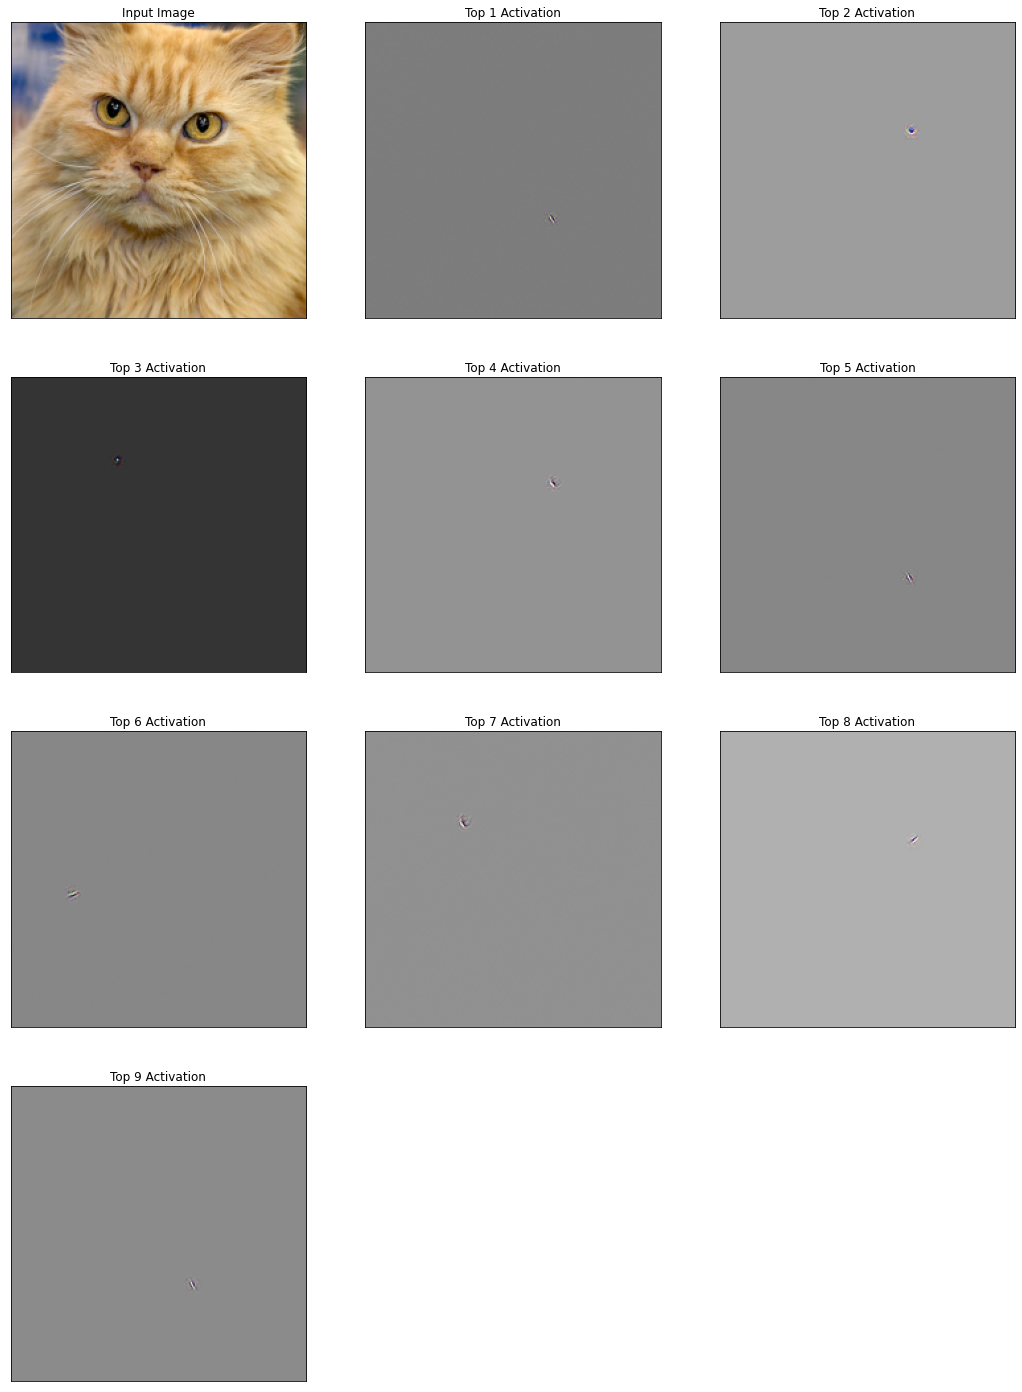

In [5]:
# Feature Maps Visualization
plt.figure(figsize=(18, 25))
plt.axis('off')

plt.subplot(4, 3, 1)
img = plt.imshow(crop_image)
img.axes.get_xaxis().set_visible(False)
img.axes.get_yaxis().set_visible(False)
plt.gca().set_title('Input Image')

for j, top_k_activation in enumerate(top_k_activations):
    plt.subplot(4, 3, j + 2)
    filter_ = top_k_activation[0].permute(1, 2, 0).numpy()
    filter_ = (filter_ - filter_.min()) / (filter_.max() - filter_.min()) * 255
    filter_ = filter_.astype(np.uint8)
    img = plt.imshow(filter_)
    img.axes.get_xaxis().set_visible(False)
    img.axes.get_yaxis().set_visible(False)
    plt.gca().set_title('Top {} Activation'.format(j+1))